In [1]:
import torch
import numpy as np

from torch import nn
from torch.nn import functional as F

from matplotlib import pyplot as plt

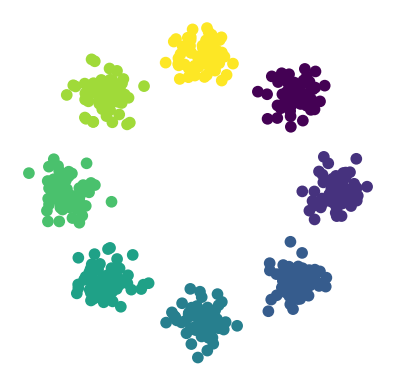

In [2]:
# generate some multimodal 2d data
n_samples, n_components = 512, 8
f_scale = 0.075

eps = torch.randn(n_samples, 2) * f_scale

mix = (torch.arange(n_samples) % n_components)
ang = mix * 2 * torch.pi / n_components

c, s = torch.cos(ang), torch.sin(ang)
R = torch.stack((c, s, -s, c,), dim=-1).reshape(n_samples, 2, 2)

X_full = torch.bmm(R, eps.add_(1 + eps).unsqueeze_(-1)).squeeze_(-1)
y_full = mix.clone()

fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=120)
ax.scatter(*X_full.T, c=y_full)
ax.set_axis_off()

<br>

In [3]:
f_train = 0.5
feeds = {
    'train': {'batch_size': 8, 'shuffle': True,},
    'test': {'batch_size': 128, 'shuffle': False,},  # UNUSED
}

n_epochs = 256
num_embeddings = 16  # number of clusters

In [4]:
from torch.utils.data import TensorDataset, DataLoader

perm = torch.randperm(n_samples)
n_train = int(f_train * n_samples)
datasets = {
    'train': TensorDataset(X_full[perm[:n_train]], y_full[perm[:n_train]]),
    'test': TensorDataset(X_full[perm[n_train:]], y_full[perm[n_train:]]),
}

feeds = {nom: DataLoader(datasets[nom], **spe)
         for nom, spe in feeds.items()}

In [5]:
from nle_toolbox.zoo.vq import VectorQuantizedVAE as VQ
from nle_toolbox.zoo.vq import VQEMAUpdater, VQLossHelper

### VQ as unsupervised denoiser, or as an online non-stationary k-means

In [6]:
from torch import Tensor
from nle_toolbox.zoo.vq import VectorQuantizedVAE
from nle_toolbox.zoo.vq import VQVAEEmbeddings, VQVAEIntegerCodes

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
from nle_toolbox.utils.env.draw import limits  # for aesthetics

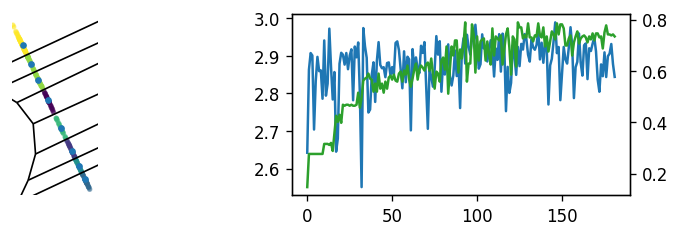

 71%|██████████████████████████████████████████████████▍                    | 182/256 [00:47<00:19,  3.83it/s]

In [ ]:
import tqdm

from IPython.display import display
from matplotlib import pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

from time import sleep

mod = nn.Sequential(
    nn.Linear(2, 2),
    # vq has special output format, so we use a handy wrapper
    VQVAEEmbeddings(VQ(num_embeddings, 2)),
    nn.Linear(2, 8),
    nn.ReLU(),
    nn.Linear(8, n_components),
).to(device)

index, vqref = next(filter(None, [
    (j, m.wrapped) if isinstance(m, VQVAEEmbeddings) else None
    for j, m in enumerate(mod)
]), (1, None))

opt = torch.optim.Adam(mod.parameters(), lr=1e-3)

# this helps us extract and pull out the vq layer-specific losses
hlp = VQLossHelper(mod, reduction='sum')

# if update is Flase then we do not make ema updates, but use
#  it to compute diagnostic entropy (health of the clustering)
#  alpha is the EMA decay rate
ema = VQEMAUpdater(mod, alpha=0.25, update=True)

eval_cpu = tuple(datasets['test'].tensors)
*eval_device, = map(lambda x: x.to(device), eval_cpu)

hist = []
for ep in tqdm.tqdm(range(n_epochs)):
    for bx, by in iter(feeds['train']):
        bx, by = bx.to(device), by.to(device)
        with hlp, ema:
            out = mod(bx)
        
        logits = out.log_softmax(dim=-1)

        clf_loss = F.nll_loss(logits, by)
        vq_ell = sum(hlp.finish().values())

        loss = clf_loss + vq_ell

        opt.zero_grad()
        # in this simple example ema updates render the vq_ell `term` non diffable
        if loss.grad_fn is not None:
            loss.backward()

        opt.step()

        ema.step()  # if ema were updating, then this would do the work!

    with torch.no_grad():
        out = mod(eval_device[0])
        y_pred = out.argmax(dim=-1).cpu()

        # intermediate representations
        rep = mod[:index](eval_device[0]).cpu()

        xlim, ylim = map(lambda l: limits(*l), zip(rep.min(0).values.tolist(), rep.max(0).values.tolist()))

    hist.append(
        tuple(ema.entropy.values()) + (
            float(vq_ell),
            float(clf_loss),
            float((eval_cpu[1] == y_pred).float().mean())
        ))

    sleep(0.025)

    ## PLOTTING

    fig, (ax, ax2) = plt.subplots(1, 2, dpi=120, figsize=(8, 2))
    if vqref is not None:
        try:
            vor = Voronoi(vqref.weight.detach().cpu().numpy())    
            voronoi_plot_2d(vor, ax=ax, show_vertices=False)
        except:
            pass
        ax.scatter(*vqref.weight.detach().cpu().numpy().T, s=5, color='C0')

    ax.scatter(
        *rep.numpy().T,
        c=y_pred.numpy(), # color='magenta',
        alpha=0.5,
        zorder=-10,
        s=5,
    )
    ax.set_aspect(1.)
    ax.set_axis_off()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    *ents, ells, clfs, acc = map(np.array, zip(*hist))
    if ents:
        ax2.plot(ents[0], label='entropy')

    ax2_ = ax2.twinx()
    ax2_.plot(acc, c='C2', label='accuracy')
#     ax2_.semilogy(clfs, c='C2', label='clf')
    if ents and False:
        ax2_.semilogy(ells, c='C1', label='vq-loss')

    display(fig, clear=True)
    plt.close()

<br>